In [30]:
# importing stuff
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

X = pd.read_csv("C:/Users/Administrator/Desktop/PFE/data/new/miscplants_Xp.csv", sep=';')
Y = pd.read_csv("C:/Users/Administrator/Desktop/PFE/data/new/miscplants_Y.csv", sep=';')
M = pd.read_csv("C:/Users/Administrator/Desktop/PFE/data/new/miscplants_M.csv", sep=';', na_values ='missing')


# For Y

In [31]:
print("\nColumn names:")
print(X.columns)
# Print number of columns
print(f"\nNumber of columns: {Y.shape[1]}")
print(f"\nNumber of rows: {Y.shape[0]}")


Column names:
Index(['1100', '1102', '1104', '1106', '1108', '1110', '1112', '1114', '1116',
       '1118',
       ...
       '2480', '2482', '2484', '2486', '2488', '2490', '2492', '2494', '2496',
       '2498'],
      dtype='object', length=700)

Number of columns: 6

Number of rows: 1608


In [32]:
# Generate frequency table for each column in M
frequency_table = M.apply(pd.Series.value_counts).fillna(0).astype(int)

# Print the frequency table
print(frequency_table)

      adf  adl   cf   cp  dmdcell  ndf
cal   861  800  500  880      820  860
test  382  356  222  391      365  382
val   287  267  166  293      274  287


In [33]:
# from ydata_profiling import ProfileReport
# import ipywidgets

# profile = ProfileReport(Y, title="Profiling Report")
# profile.to_notebook_iframe()

<Figure size 1000x600 with 0 Axes>

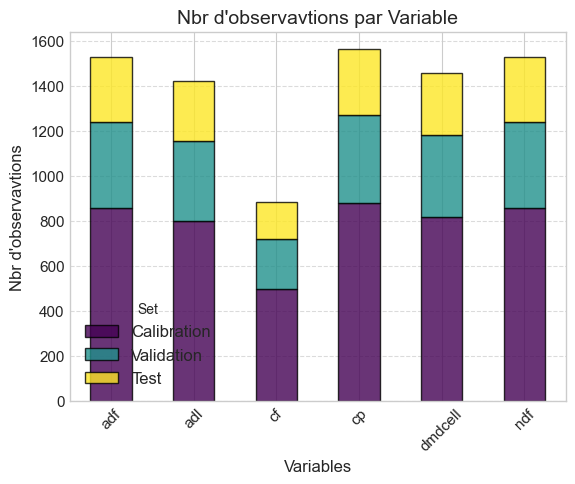

In [34]:
# Plot bar graph fro the frequencies
counts = M.apply(pd.Series.value_counts).T  # Transpose to get variables as index


plt.figure(figsize=(10, 6))
counts.plot(kind="bar", stacked=True, colormap="viridis", edgecolor="black", alpha=0.8)

plt.xlabel("Variables")
plt.ylabel("Nbr d'observavtions")
plt.title("Nbr d'observavtions par Variable")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend(title="Set", labels=["Calibration", "Validation", "Test"])
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


# For X


# Exploratory data analysis

In [35]:
def split_data(Var):

    if Var not in Y.columns or Var not in M.columns:
        raise ValueError(f"Errer Erreur Erreur ! ! !")

    mask = M[Var]

    # Split X and Y based on M.csv values
    X_cal = X[mask == 'cal']
    Y_cal = Y.loc[X_cal.index, Var]

    X_val = X[mask == 'val']
    Y_val = Y.loc[X_val.index, Var]

    X_test = X[mask == 'test']
    Y_test = Y.loc[X_test.index, Var]

    return (X_cal, Y_cal), (X_val, Y_val), (X_test, Y_test)

In [36]:
def perform_pca(X_cal, X_val, X_test, var, C1, C2, C3, ncomp=10):
    # Merge calibration and validation sets to create the training set
    X_train = pd.concat([X_cal, X_val])

    # Apply PCA (3 components for 3D plot)
    pca = PCA(n_components=ncomp)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Explained variance per component
    explained_variance = pca.explained_variance_ratio_

    # Create figure with two subplots
    fig = plt.figure(figsize=(12, 5))

    # 3D Scatter Plot for PCA projection
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(X_train_pca[:, C1], X_train_pca[:, C2], X_train_pca[:, C3], 
                alpha=0.5, color='blue', label="Training (Cal + Val)")
    ax1.scatter(X_test_pca[:, C1], X_test_pca[:, C2], X_test_pca[:, C3], 
                alpha=0.6, color='red', label="Test")
    ax1.set_xlabel(f"PC {C1}")
    ax1.set_ylabel(f"PC {C2}")
    ax1.set_zlabel(f"PC {C3}")
    ax1.set_title("Projection PCA en 3D (variable = {})".format(var))
    ax1.legend()
    ax1.grid(True)

    # Explained Variance Plot
    ax2 = fig.add_subplot(122)
    ax2.plot(range(1, len(explained_variance) + 1), explained_variance, 
             color='black', alpha=0.7, marker='o')
    ax2.set_xlabel("Nbr de Composantes Principales")
    ax2.set_ylabel("Variance Expliquée")
    ax2.set_title("Variance Expliquée par Composante")
    ax2.grid(True)

    # Show plots
    plt.tight_layout()
    plt.show()

In [37]:
def plot_histogram(Y_cal, Y_val, Y_test, var):

    Y_train = pd.concat([Y_cal, Y_val])

    mean_train = Y_train.mean()
    mean_test = Y_test.mean()

    plt.figure(figsize=(10, 6))
    
    # Plot histograms with KDE
    sns.histplot(Y_train, color='blue', alpha=0.7, 
                 label="Training (Cal + Val)", kde=True, bins=30)
    sns.histplot(Y_test, color='red', alpha=0.5, 
                 label="Test", kde=True, bins=30)

    # Add mean lines
    plt.axvline(mean_train, color='blue', linestyle='dashed', linewidth=1.5, 
                label=f"Mean Train: {mean_train:.2f}")
    plt.axvline(mean_test, color='red', linestyle='dashed', linewidth=1.5, 
                label=f"Mean Test: {mean_test:.2f}")

    plt.xlabel(var)
    plt.ylabel("Fréquence")
    plt.title(f"Distribution of {var} with Normality Test p-values")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

In [93]:
Var = 'adf'  # Change this to the variable you want to analyze
(X_cal, Y_cal), (X_val, Y_val), (X_test, Y_test) = split_data(Var)
Y_train = pd.concat([Y_cal, Y_val])
X_train = pd.concat([X_cal, X_val])

# Summary statistics
summary_stats = pd.DataFrame({
    "Training (Cal + Val)": Y_train.describe(),
    "Test": Y_test.describe()
})
print("Statistiaues:/n", summary_stats)

Statistiaues:/n        Training (Cal + Val)        Test
count           1148.000000  382.000000
mean              33.221063   33.231597
std                9.884037    9.997747
min                9.200000    8.770000
25%               25.590000   25.587500
50%               32.945000   32.940000
75%               39.832500   39.862500
max               65.980000   66.910000


In [ ]:
import pandas as pd

# Desired statistics
stats = {
    "Mean": pd.Series.mean,
    "Median": pd.Series.median,
    "Std": pd.Series.std,
    "Min": pd.Series.min,
    "Max": pd.Series.max
}

# Storage for rows
rows = []

# Loop through all variables
for var in Y.columns:
    try:
        # Split data per variable
        (X_cal, Y_cal), (X_val, Y_val), (X_test, Y_test) = split_data(var)
        Y_train = pd.concat([Y_cal, Y_val])

        # Compute stats, skipping NaNs
        for stat_name, stat_func in stats.items():
            train_stat = stat_func(Y_train)
            test_stat = stat_func(Y_test)
            rows.append(((var, stat_name), [train_stat, test_stat]))

    except Exception as e:
        print(f"⚠️ Could not process variable '{var}': {e}")

# Create final DataFrame
summary_df = pd.DataFrame(
    data=[row[1] for row in rows],
    index=pd.MultiIndex.from_tuples([row[0] for row in rows], names=["Variable", "Statistic"]),
    columns=["Training (Cal + Val)", "Test"]
)

# Optional: Round values for clean display
summary_df = summary_df.round(3)

print("Statistiques :\n", summary_df)


Statistiques :
                     Training (Cal + Val)    Test
Variable Statistic                              
adf      Mean                     33.221  33.232
         Median                   32.945  32.940
         Std                       9.884   9.998
         Min                       9.200   8.770
         Max                      65.980  66.910
adl      Mean                     10.950  10.983
         Median                    8.760   8.780
         Std                       7.678   7.778
         Min                       0.930   0.730
         Max                      42.820  43.070
cf       Mean                     28.803  28.808
         Median                   28.850  28.840
         Std                       9.048   9.172
         Min                       7.930   7.810
         Max                      52.140  52.210
cp       Mean                     11.375  11.393
         Median                   11.010  10.990
         Std                       4.575   4.658
    

In [ ]:
# Print column names
print("/nColumn names:")
print(X.columns)
# Print number of columns
print(f"\nNumber of columns: {X.shape[1]}")
print(f"\nNumber of rows: {X.shape[0]}")


/nColumn names:
Index(['1100', '1102', '1104', '1106', '1108', '1110', '1112', '1114', '1116',
       '1118',
       ...
       '2480', '2482', '2484', '2486', '2488', '2490', '2492', '2494', '2496',
       '2498'],
      dtype='object', length=700)

Number of columns: 700

Number of rows: 1608


In [ ]:
# Generate descriptive statistics
print("\nDescriptive analysis:")
print(X.describe())



Descriptive analysis:
              1100         1102         1104         1106         1108  \
count  1608.000000  1608.000000  1608.000000  1608.000000  1608.000000   
mean     -0.000348    -0.000289    -0.000180    -0.000040     0.000098   
std       0.000418     0.000396     0.000328     0.000229     0.000129   
min      -0.003419    -0.003155    -0.002496    -0.001556    -0.000635   
25%      -0.000475    -0.000415    -0.000289    -0.000124     0.000039   
50%      -0.000261    -0.000212    -0.000123    -0.000012     0.000100   
75%      -0.000078    -0.000034     0.000027     0.000103     0.000169   
max       0.000302     0.000393     0.000478     0.000543     0.000571   

              1110         1112         1114         1116         1118  ...  \
count  1608.000000  1608.000000  1608.000000  1608.000000  1608.000000  ...   
mean      0.000191     0.000201     0.000214     0.000236     0.000259  ...   
std       0.000077     0.000087     0.000096     0.000102     0.000104  .

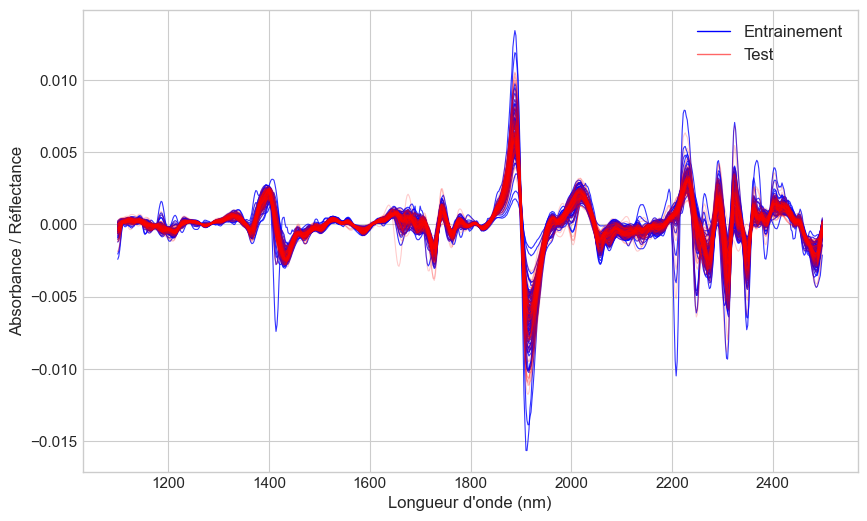

In [49]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Plot wavelengths
num_samples = 100
train_samples = X_train.sample(n=min(num_samples, len(X_train)), random_state=42)
test_samples = X_test.sample(n=min(num_samples, len(X_test)), random_state=42)

wavelengths = np.arange(1100, 1100 + X_train.shape[1] * 2, 2)  

# Plot spectral curves
plt.figure(figsize=(10, 6))

for _, row in train_samples.iterrows():
    plt.plot(wavelengths, row, color='blue', alpha=0.8, linewidth=0.8)

for _, row in test_samples.iterrows():
    plt.plot(wavelengths, row, color='red', alpha=0.2, linewidth=0.8)

plt.xlabel("Longueur d'onde (nm)")
plt.ylabel("Absorbance / Réflectance")
plt.grid(True)

# Correct legend using custom handles
custom_lines = [
    Line2D([0], [0], color='blue', lw=1, label='Entrainement'),
    Line2D([0], [0], color='red', lw=1, label='Test', alpha=0.6)
]
plt.legend(handles=custom_lines, loc='upper right')

plt.show()


In [ ]:
# # Moyen pour chaque wavelenght pour comparer
# mean_train = X_train.mean(axis=0)
# mean_test = X_test.mean(axis=0)

# # Generate wavelength values assuming 2nm intervals
# wavelengths = np.arange(1100, 1100 + X_train.shape[1] * 2, 2)

# # Plot the mean spectra
# plt.figure(figsize=(10, 5))
# plt.plot(wavelengths, mean_train, label="Mean Training (Cal + Val)", color='blue')
# plt.plot(wavelengths, mean_test, label="Mean Test", color='red', linestyle='dashed')

# # Labels and styling
# plt.xlabel("Wavelength (nm)")
# plt.ylabel("Mean Absorbance / Reflectance")
# plt.title("Mean Spectra for Training and Test Sets")
# plt.legend()
# plt.grid(True)

# plt.show()

In [79]:
Var = 'ndf'  # Change this to the variable you want to analyze

# ACP

In [80]:
def perform_pca_2d(X_cal, X_val, X_test, var, C1, C2, ncomp=10):
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA

    # Merge calibration and validation sets to form training set
    X_train = pd.concat([X_cal, X_val])

    # Apply PCA
    pca = PCA(n_components=ncomp)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Explained variance per component
    explained_variance = pca.explained_variance_ratio_

    # === 2D Scatter Plot ===
    fig1 = plt.figure(figsize=(8, 6))
    plt.scatter(X_train_pca[:, C1], X_train_pca[:, C2], 
                alpha=0.5, color='blue', label="Training")
    plt.scatter(X_test_pca[:, C1], X_test_pca[:, C2], 
                alpha=0.6, color='red', label="Test")
    plt.xlabel(f"PC {C1+1}")
    plt.ylabel(f"PC {C2+1}")
    plt.legend(frameon=True, facecolor='white', edgecolor='black')  # Legend box style
    plt.grid(True)
    plt.tight_layout()
    scatter_filename = f"C:/Users/Administrator/Desktop/PFE_Tex/images/PCA_2D_projection_{var}.pdf"
    plt.savefig(scatter_filename)
    plt.show()

    # === Explained Variance Plot ===
    fig2 = plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance,
             color='black', alpha=0.7, marker='o')
    plt.xlabel("Composante Principale")
    plt.ylabel("Variance Expliquée")
    plt.xticks(range(1, len(explained_variance) + 1))
    plt.grid(True)
    plt.tight_layout()
    variance_filename = f"C:/Users/Administrator/Desktop/PFE_Tex/images/PCA_explained_variance_{var}.pdf"
    plt.savefig(variance_filename)
    plt.show()

    print(f"Plots saved as: '{scatter_filename}' and '{variance_filename}'")


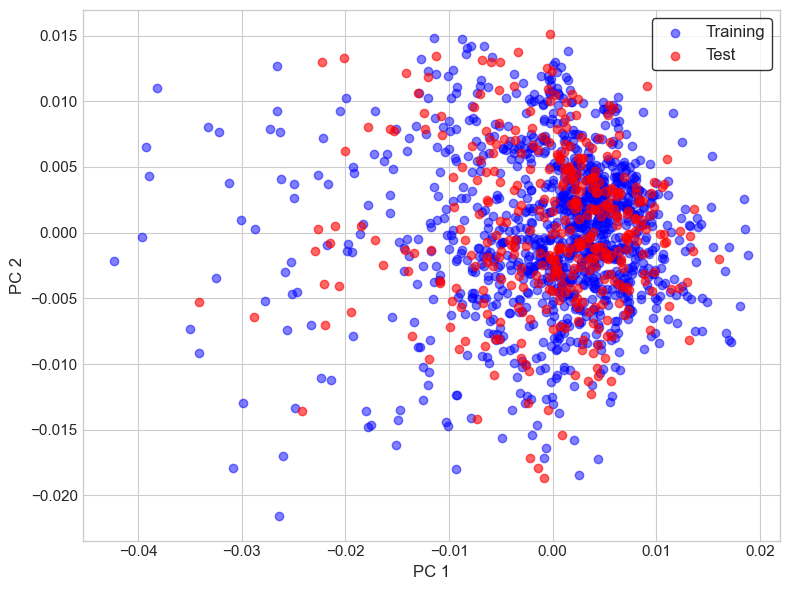

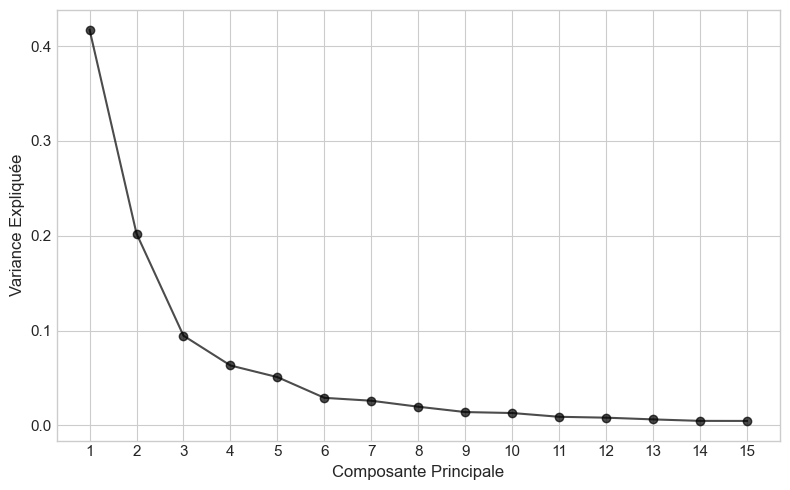

Plots saved as: 'C:/Users/Administrator/Desktop/PFE_Tex/images/PCA_2D_projection_ndf.pdf' and 'C:/Users/Administrator/Desktop/PFE_Tex/images/PCA_explained_variance_ndf.pdf'


In [81]:
perform_pca_2d(X_cal, X_val, X_test, Var, 0, 1, ncomp=15)

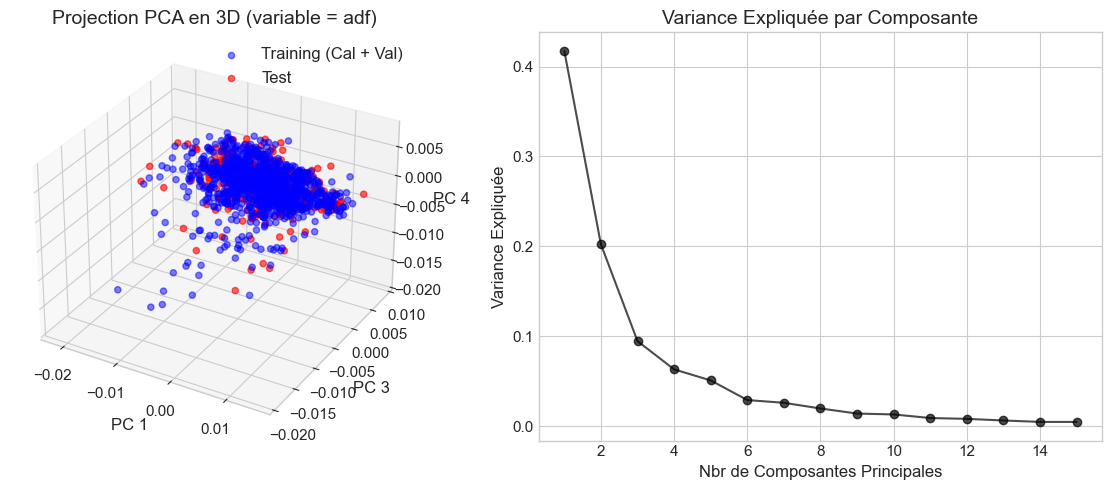

In [52]:
perform_pca(X_cal, X_val, X_test, Var, 1, 3, 4, ncomp=15)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def visualize_distribution_split(Y_cal, Y_val, Y_test, var):
    """
    Visually compares training and test distributions using both 
    a KDE plot and a Q-Q plot.
    """
    Y_train = pd.concat([Y_cal, Y_val]).dropna()
    Y_test = Y_test.dropna()

    # --- Use a clean, professional plot style ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Visual Comparison of Train vs. Test Distributions for "{var}"', fontsize=18)

    # --- Plot 1: Refined KDE Plot ---
    sns.kdeplot(Y_train, ax=axes[0], color='royalblue', fill=True, 
                alpha=0.2, linewidth=2.5, label='Training Set')
    sns.kdeplot(Y_test, ax=axes[0], color='darkorange', fill=True, 
                alpha=0.2, linewidth=2.5, label='Test Set')
    axes[0].set_title('Overlaid Density (KDE)', fontsize=14)
    axes[0].set_xlabel(var, fontsize=12)
    axes[0].set_ylabel('Density', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

    # --- Plot 2: Q-Q Plot (The Superior Visual Test) ---
    quantiles_train = np.percentile(Y_train, range(101))
    quantiles_test = np.percentile(Y_test, range(101))
    
    axes[1].scatter(quantiles_train, quantiles_test, c='royalblue', alpha=0.8, s=50)
    
    # Add the 45-degree reference line
    max_val = max(np.max(quantiles_train), np.max(quantiles_test))
    min_val = min(np.min(quantiles_train), np.min(quantiles_test))
    axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', 
                 linewidth=2, label='Perfect Match Line')

    axes[1].set_title('Quantile-Quantile (Q-Q) Plot', fontsize=14)
    axes[1].set_xlabel('Training Set Quantiles', fontsize=12)
    axes[1].set_ylabel('Test Set Quantiles', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[1].set_aspect('equal', 'box') # Critical for correct visual interpretation

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
    plt.show()

# --- Example Usage ---
# Y_cal_demo = pd.Series(np.random.normal(10, 2, 500))
# Y_val_demo = pd.Series(np.random.normal(10.1, 2.1, 500))
# Y_test_demo = pd.Series(np.random.normal(10.2, 2.0, 400))
#
# visualize_distribution_split(Y_cal_demo, Y_val_demo, Y_test_demo, 'Engine Temperature')

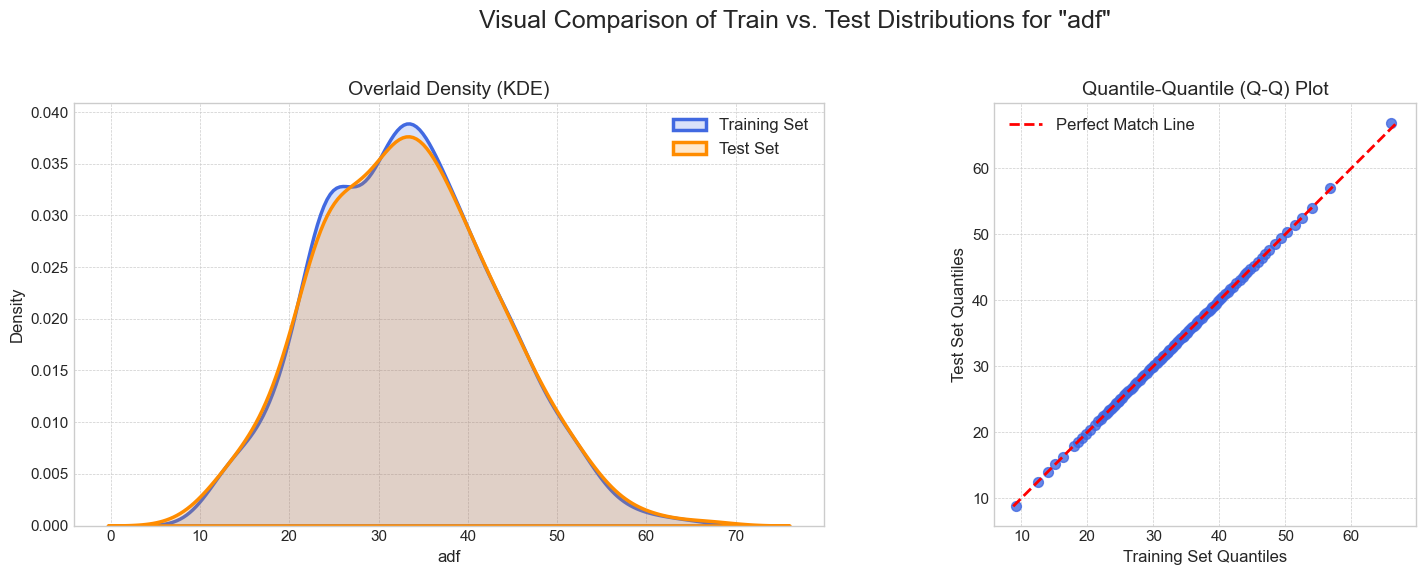

In [54]:
visualize_distribution_split(Y_cal, Y_val, Y_test, Var)

In [98]:
def plot_histogram(Y_cal, Y_val, Y_test, var):
    Y_train = pd.concat([Y_cal, Y_val])

    plt.figure(figsize=(10, 6))
    
    # Plot only histograms (no KDE)
    sns.histplot(Y_train, color='blue', alpha=0.7, label="Training", bins=30)
    sns.histplot(Y_test, color='red', alpha=0.7, label="Test", bins=30)

    plt.xlabel(var)
    plt.ylabel("Fréquence")
    plt.title(f"Distribution de la variable {var}")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    scatter_filename = f"C:/Users/Administrator/Desktop/PFE_Tex/images/distribution_{var}.pdf"
    plt.savefig(scatter_filename)
    plt.show()

In [108]:
Var = 'ndf'  # Change this to the variable you want to analyze

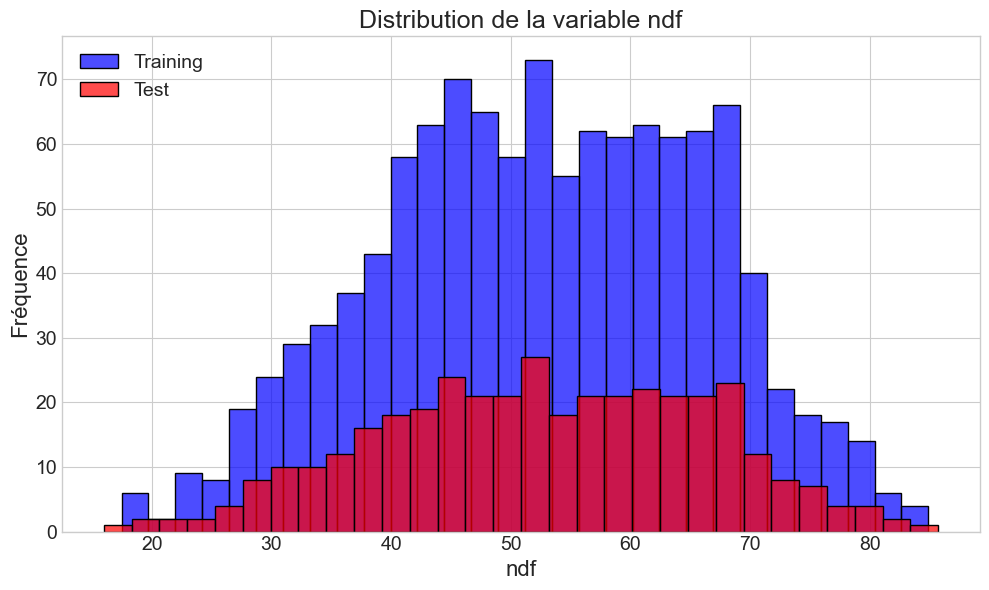

In [109]:
plot_histogram(Y_cal, Y_val, Y_test, Var)

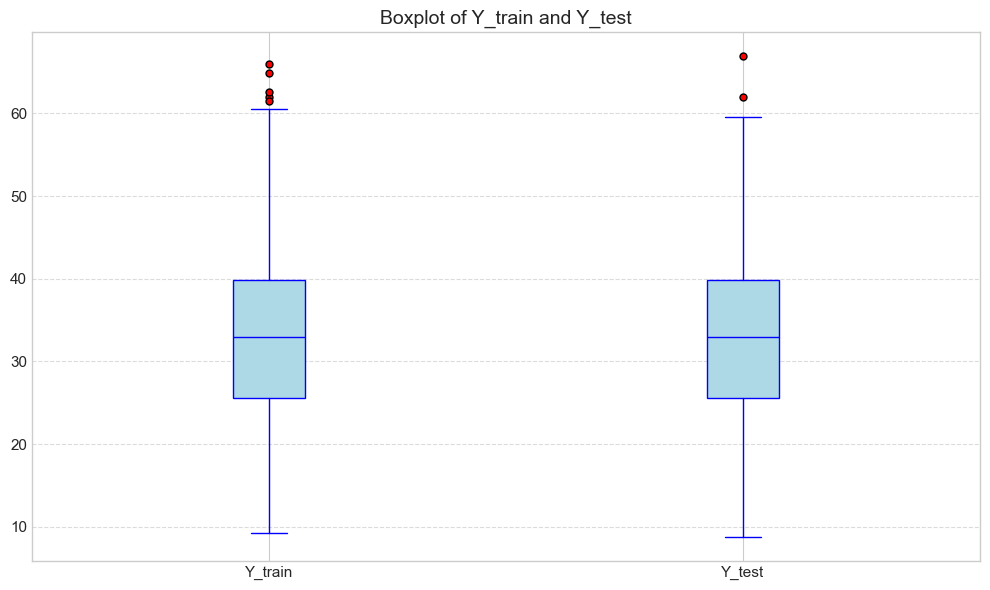

In [86]:
# boxplots
plt.figure(figsize=(10, 6))

plt.boxplot([Y_train, Y_test], labels=['Y_train', 'Y_test'], patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), whiskerprops=dict(color='blue'), capprops=dict(color='blue'), medianprops=dict(color='blue'), flierprops=dict(marker='o', markerfacecolor='red', markersize=5))

plt.title('Boxplot of Y_train and Y_test')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Pairplot pour tt les Vars

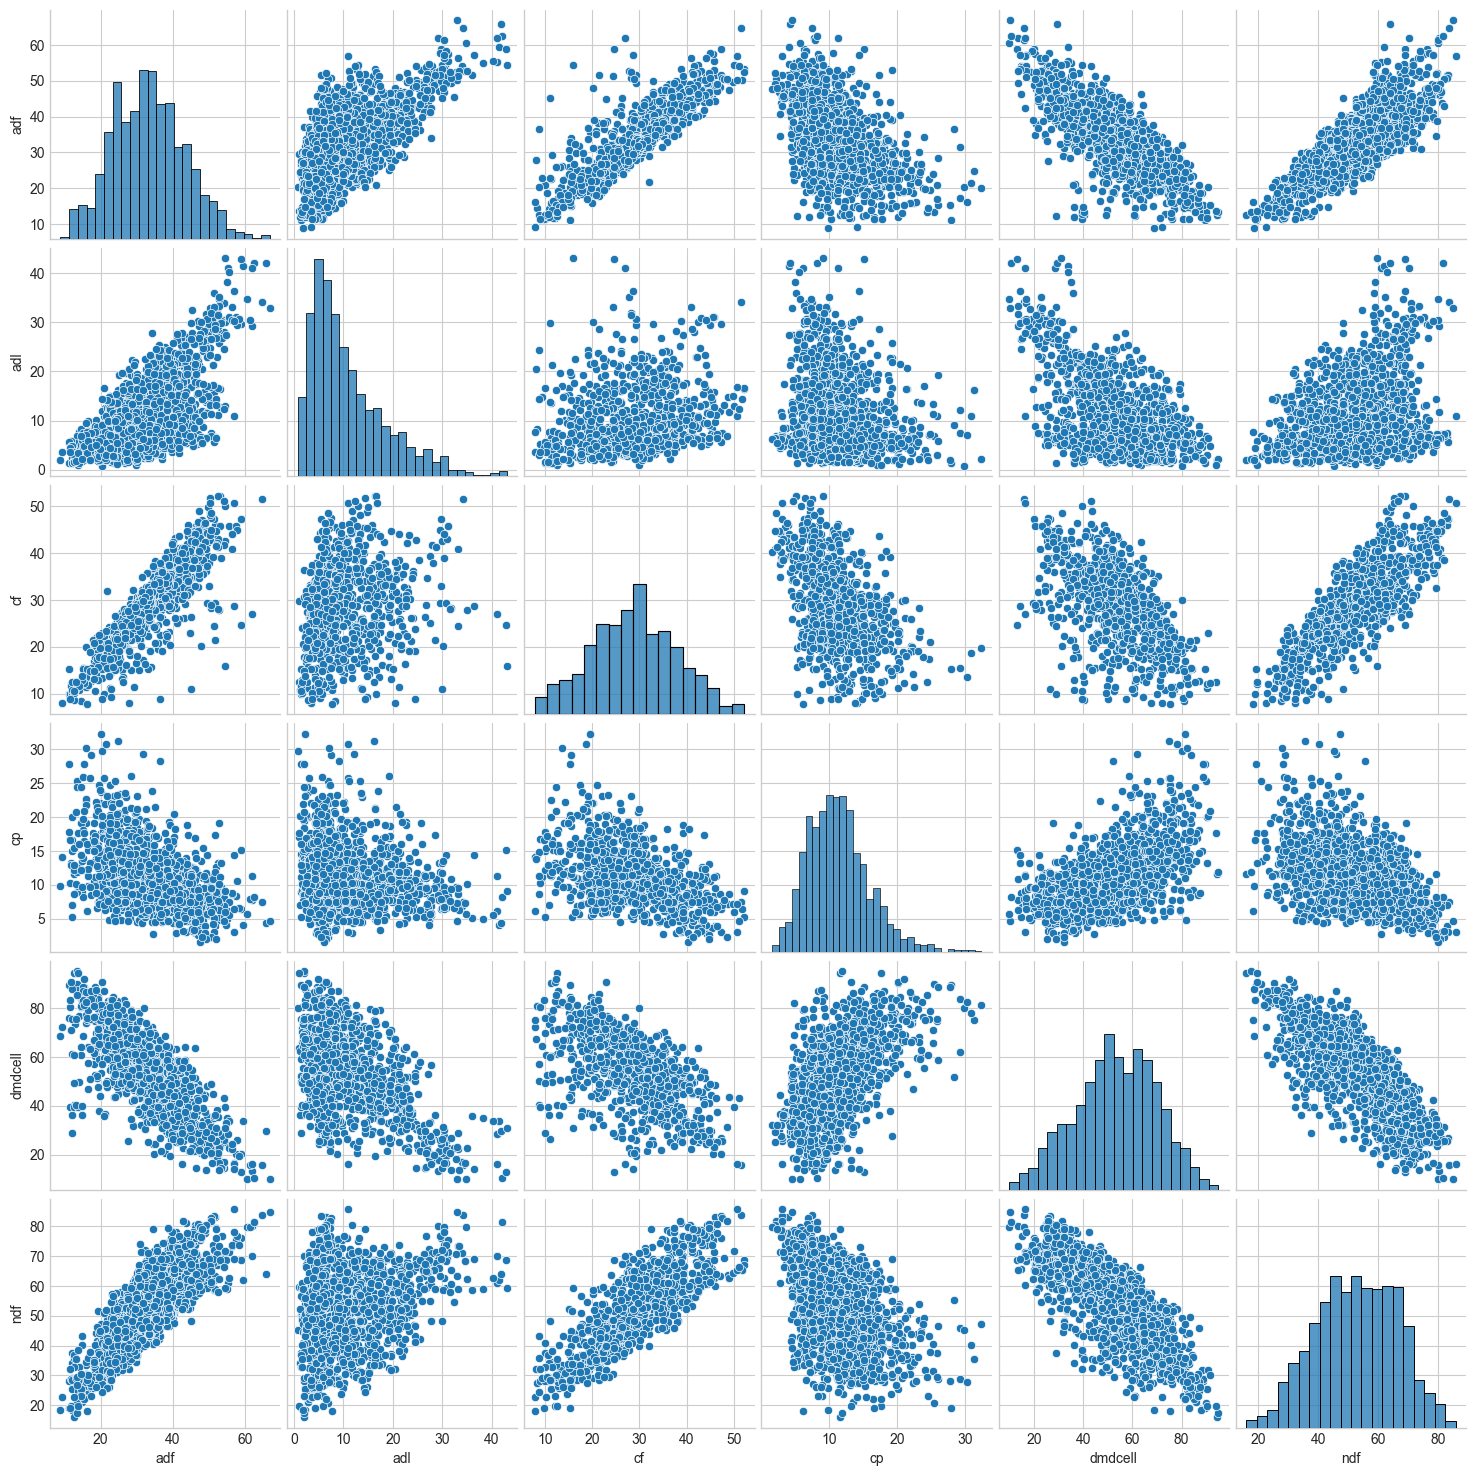

In [ ]:
sns.pairplot(Y, diag_kind='hist')

# Show the plot
plt.show()

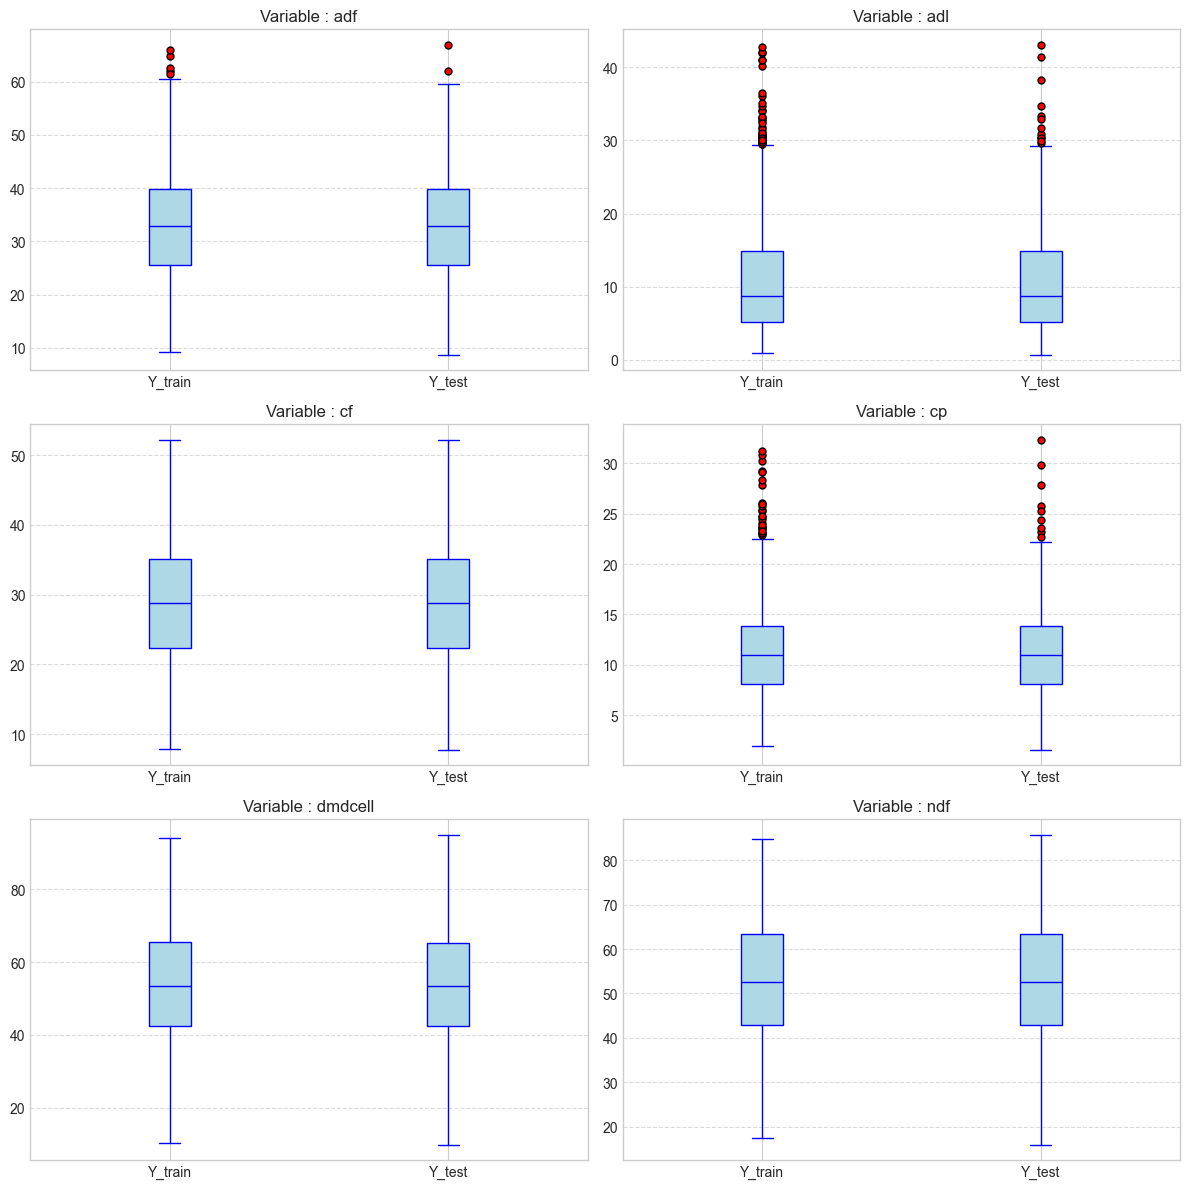

In [ ]:
# List of variables to iterate over
variables = ["adf", "adl", "cf", "cp", "dmdcell", "ndf"]

# Create figure (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # Adjust size if needed

# Loop through variables and create boxplots
for i, var in enumerate(variables):
    row, col = divmod(i, 2)  # Because 2 columns now

    # Get the datasets
    (X_cal, Y_cal), (X_val, Y_val), (X_test, Y_test) = split_data(var)
    Y_train = pd.concat([Y_cal, Y_val])
    X_train = pd.concat([X_cal, X_val])

    # Create boxplot
    axes[row, col].boxplot([Y_train, Y_test], labels=['Y_train', 'Y_test'],
                           patch_artist=True,
                           boxprops=dict(facecolor='lightblue', color='blue'),
                           whiskerprops=dict(color='blue'),
                           capprops=dict(color='blue'),
                           medianprops=dict(color='blue'),
                           flierprops=dict(marker='o', markerfacecolor='red', markersize=5))

    # Titles and formatting
    axes[row, col].set_title(f'Variable : {var}')
    axes[row, col].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show plot
plt.tight_layout()
# Save the figure as a PDF
plt.savefig("C:/Users/Administrator/Desktop/PFE_Tex/images/boxplots_variables.pdf", format='pdf')
# Show the plot
plt.show()


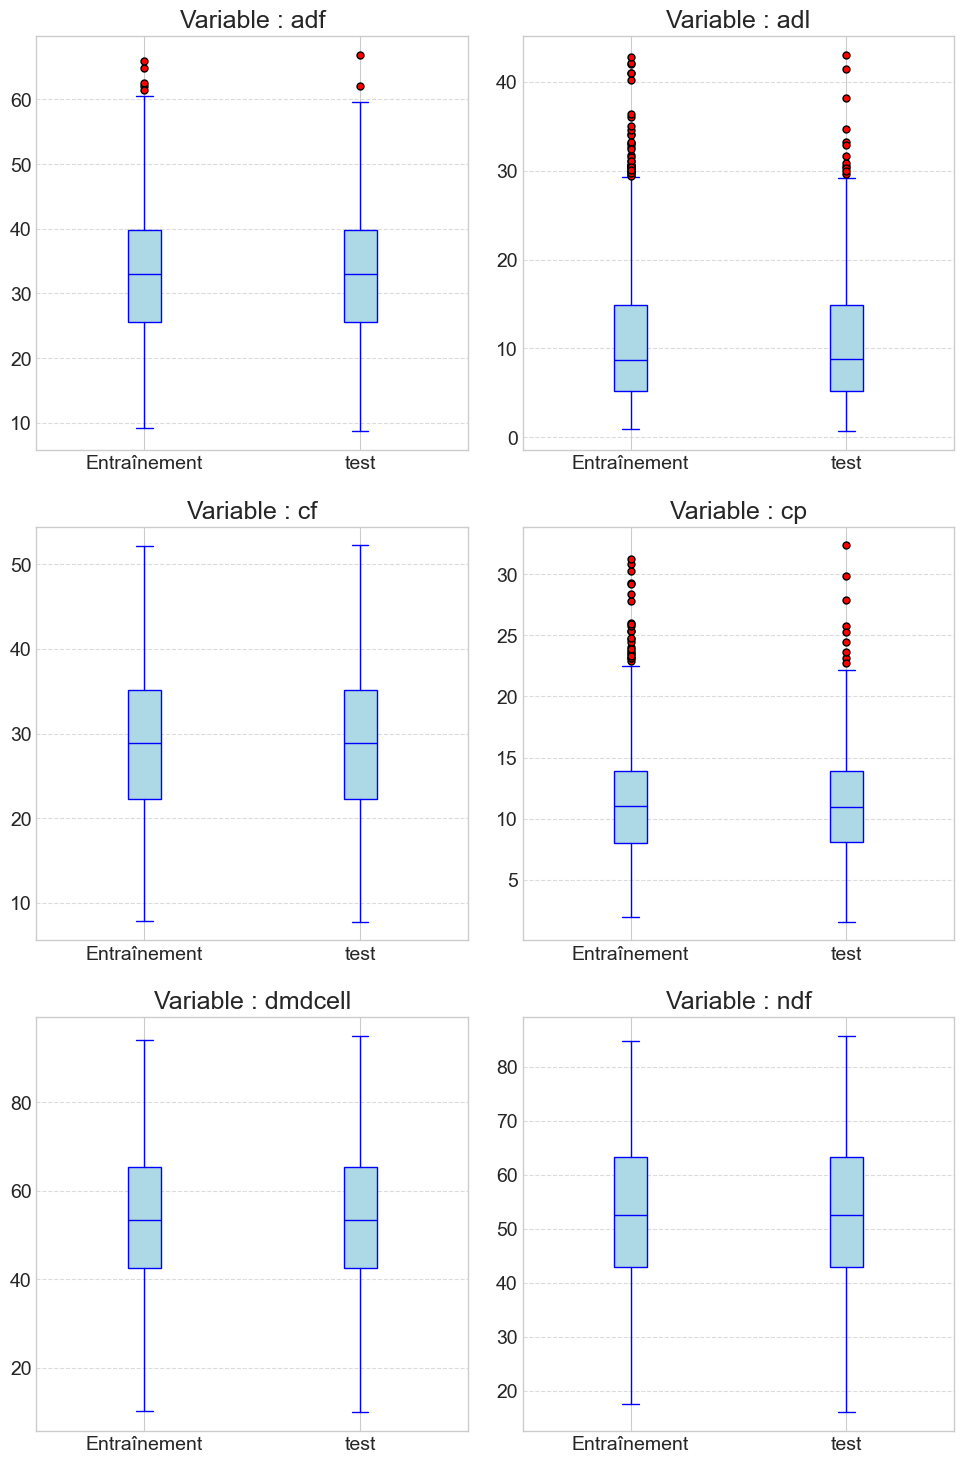

In [97]:
# Increase global font sizes
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})


# Create figure (3 rows, 2 columns), taller figure
fig, axes = plt.subplots(3, 2, figsize=(10, 15))  # Wider Y-axis room

# List of variables
variables = ["adf", "adl", "cf", "cp", "dmdcell", "ndf"]

# Loop through variables
for i, var in enumerate(variables):
    row, col = divmod(i, 2)

    (X_cal, Y_cal), (X_val, Y_val), (X_test, Y_test) = split_data(var)
    Y_train = pd.concat([Y_cal, Y_val])
    X_train = pd.concat([X_cal, X_val])

    axes[row, col].boxplot([Y_train, Y_test], labels=['Entraînement', 'test'],
                           patch_artist=True,
                           boxprops=dict(facecolor='lightblue', color='blue'),
                           whiskerprops=dict(color='blue'),
                           capprops=dict(color='blue'),
                           medianprops=dict(color='blue'),
                           flierprops=dict(marker='o', markerfacecolor='red', markersize=5))

    axes[row, col].set_title(f'Variable : {var}')
    axes[row, col].grid(axis='y', linestyle='--', alpha=0.7)

# Apply tighter layout with padding
plt.tight_layout(pad=2.0)

# Save to PDF
plt.savefig("C:/Users/Administrator/Desktop/PFE_Tex/images/boxplots_variables.pdf", format='pdf')

# Show the plot
plt.show()
